# DeepScence Tutorial

## Table of Contents
- [1. Intro](#1-intro)
- [2. Dataset A — In-vitro IMR-90 dataset](#2-dataset-a--in-vitro-imr-90-dataset)
  - [2.1 Prepare input for DeepScence](#21-prepare-input-for-deepscence)
  - [2.2 Run DeepScence & Visualize](#22-run-deepscence--visualize)
- [3. Dataset B — In-vivo mouse muscle data](#3-dataset-b--in-vivo-mouse-muscle-data)
  - [3.1 Prepare input for DeepScence](#31-prepare-input-for-deepscence)
  - [3.2 Run DeepScence & Visualize](#32-run-deepscence--visualize)
- [4. Notes & Tips](#4-notes--tips)

In [1]:
import scanpy as sc
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from DeepScence.api import DeepScence
from dca.api import dca

### 1. Intro
DeepScence is an unsupervised machine learning model based on autoencoders for accurately scoring and identifying senescent cells in single-cell RNA-seq (scRNA-seq) and spatial transcriptomics datasets.

DeepScence take as input a properly filtered, ideally denoised expression matrix in the form of `AnnData` object. If start with raw count matrix, we recommend performing denoise using `DCA` or other methods first. 

DeepScence outputs:
- A continuous senescence score (`adata.obs["ds"]`)
- A binary classification for senescent cells and normal cells (`adata.obs["binary"]`)

***Note***:
For datasets collected from cell line where only one cell type is present, please refer to the IMR-90 example below. For datasets collected in-vivo where multiple cell types are present, please refer to the second example for controlling unwanted covariates.


## 2. Example: In-vitro IMR-90 dataset
This is an in-vitro scRNA-seq dataset for IMR-90 cell line, with senescence induced by OSKM factors. Senescence information of cells are labeled as ground truth. Note this data set has only one cell type that is IMR-90.


### 2.1 Prepare input for DeepScence

In [2]:
counts = pd.read_csv('./origin_matrix_GSE94980.txt', sep = '\t').T
adata = sc.AnnData(counts)
adata.obs['condition'] = [x.split('_')[-1]=='OSKM' for x in adata.obs_names]
adata.obs["SnC"] = (adata.obs["condition"]).astype(int)
adata.X = adata.X.astype(np.float32)

# denoise
sc.pp.filter_genes(adata, min_cells=1)
dca(adata)

dca: Successfully preprocessed 16871 genes and 200 cells.
dca: Calculating reconstructions...


### 2.2 Run DeepScence and visualize

[2025-08-13 20:26] GPU not available, using CPU...
[2025-08-13 20:26] Input is not count, processed 16871 genes and 200 cells.
[2025-08-13 20:26] Using 35 genes in the gene set for scoring.
[2025-08-13 20:26] Lambda provided, capturing scores in 2 neurons.
[2025-08-13 20:26] Training on 180 cells, validate on 20 cells.
100%|██████████| 300/300 [00:01<00:00, 289.93it/s]


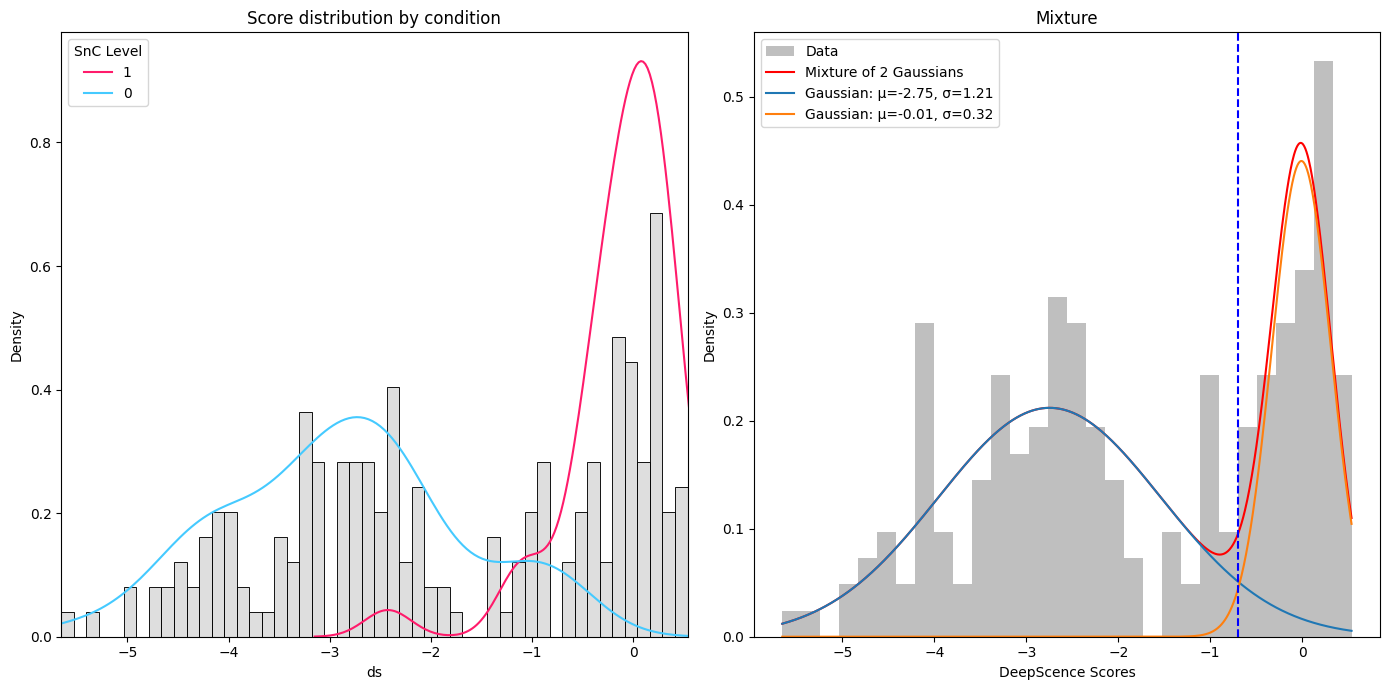

In [3]:
adata = DeepScence(adata, binarize=True)

2025-08-13 20:27:00,189 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-08-13 20:27:00,192 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


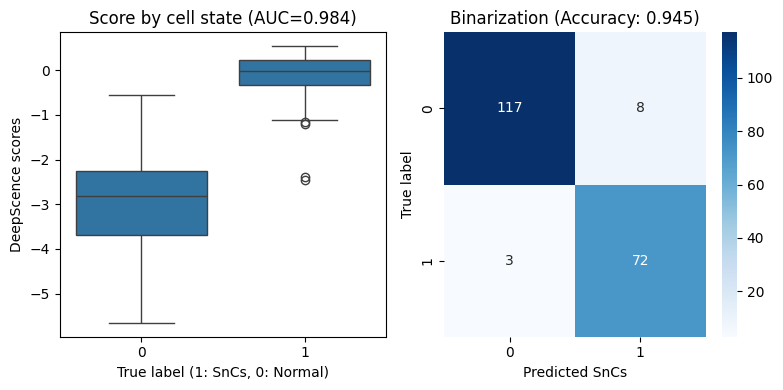

In [4]:
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

binary_numeric = adata.obs["binary"].map({"SnC": 1, "Normal": 0}).values
auroc = roc_auc_score(adata.obs["SnC"].values, adata.obs["ds"].values)
accuracy = accuracy_score(binary_numeric, adata.obs["SnC"])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
sns.boxplot(x=adata.obs["SnC"], y=adata.obs["ds"], ax=ax1)
ax1.set_title(f"Score by cell state (AUC={auroc:.3f})")
ax1.set_xlabel("True label (1: SnCs, 0: Normal)")
ax1.set_ylabel("DeepScence scores")

cm = confusion_matrix(binary_numeric, adata.obs["SnC"])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title(f"Binarization (Accuracy: {accuracy:.3f})")
ax2.set_xlabel("Predicted SnCs")
ax2.set_ylabel("True label")

plt.tight_layout()
plt.show()

## 3. Example: In-vivo mouse muscle data
This is an in-vivo scRNA-seq dataset collected on mouse muscle with senescence induced by CTX toxin. Cells labeled as `adata.obs["stim"] == "CTX"` are injured cells which are more senescence-enriched.

Note there are multiple cell types present in this dataset, and we want to control for cell type variation when running DeepScence. To achieve this, set `adata.obs["b"] = "adata.obs["celltype]` to remove "batch" effect, or any unwanted variation in the data, prior to running DeepScence. This step is recommended for any in-vivo datasets with multiple cell types present.

### 3.1 Prepare input for DeepScence

In [5]:
adata = sc.read_h5ad("./mouse_muscle.h5ad")
sc.pp.filter_genes(adata, min_cells=1)
dca(adata) # This step might take some time...

dca: Successfully preprocessed 14946 genes and 3591 cells.
dca: Calculating reconstructions...


## 3.2 Run DeepScence and Visualize

In [6]:
# running mouse dataset
adata.obs["b"] = adata.obs["celltype"].astype(str)
adata = DeepScence(adata, binarize=False, species="mouse")


[2025-08-13 20:28] GPU not available, using CPU...
[2025-08-13 20:28] Input is not count, processed 14946 genes and 3591 cells.
[2025-08-13 20:28] Using 35 genes in the gene set for scoring.
[2025-08-13 20:28] Lambda provided, capturing scores in 2 neurons.
[2025-08-13 20:28] Training on 3232 cells, validate on 359 cells.
 89%|████████▉ | 268/300 [00:10<00:01, 26.76it/s]


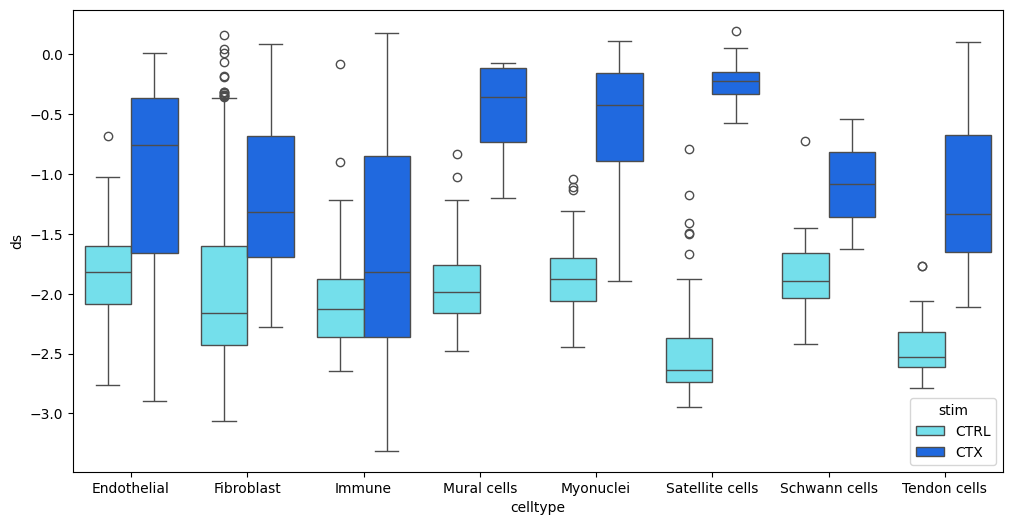

In [7]:
# Plot senescence score distributions comparing conditions
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=adata.obs,
    x="celltype",
    y="ds",
    hue="stim",
    palette=["#60efff", "#0061ff"]
)
plt.show()